# Изучение распределения прилагательных <i>niger</i> и <i>ater</i> в латинской прозе и поэзии

## Папоротский Михаил, БКЛ181

### Презентация: https://docs.google.com/presentation/d/1GNGSgFR8USmTWK3aI7Xk2Yki7qpLq7s-9veaMMf3tyc/edit?usp=sharing


Для начала подключаем все необходимое:

In [1]:
import os
import re
from cltk.corpus.utils.importer import CorpusImporter
from cltk.stem.lemma import LemmaReplacer
from cltk.stem.latin.j_v import JVReplacer
import sqlite3
import matplotlib.pyplot as plt
import collections

corpus_importer = CorpusImporter('latin')
corpus_importer.import_corpus('latin_models_cltk')

lemmatizer = LemmaReplacer('latin')
j = JVReplacer()

conn = sqlite3.connect('latin.db')
c = conn.cursor()

Обрабатываем папку с прозой и папку с поэзией: лемматизируем каждый текст (предварительно удалив оттуда пунктуацию), находим количество употреблений нужных нам прилагательных и записываем* данные в датабазу**.

<i>* на месте автора я поставил прочерк, потому что нужных нам авторов проще записать уже вручную пост-фактум.</i>

<i>** таблица в датабазе содержит следующие колонки: имя файла, тип текста, автор, число niger, число ater, число слов в тексте.</i>

In [2]:
def find_adj(directory):
    for filename in os.listdir(directory): #обходим циклом каждый файл в папке
        
        niger_count = 0
        ater_count = 0
        
        path = os.path.join(directory, filename)
        with open(path, encoding='utf-8-sig') as f: #считываем текст из файла
            text = f.read()
            
        text = text.lower()
        text = re.sub(r'[^\w\s]','',text) #обрабатываем текст (пунктуация, регистр)
        j.replace(text) #v,j -> u,i
        lemmatized_text = lemmatizer.lemmatize(text) #лемматизируем текст
        
        for lemma in lemmatized_text: #считаем кол-во исследуемых прилагательных в тексте
            if lemma == 'niger':
                niger_count += 1
            if lemma == 'ater1':
                ater_count += 1
            
        len_of_text = len(lemmatized_text) #считаем кол-во слов в тексте
        
        c.execute("INSERT INTO texts VALUES (?, ?, ?, ?, ?, ?) ", 
                  (filename, directory, '–', niger_count, ater_count, len_of_text))
        conn.commit()


find_adj('prose')
find_adj('poetry')

Смотрим, сколько всего слов в наших корпусах:

In [3]:
word_sum = list(c.execute('SELECT sum(word_sum), type from texts GROUP by type'))
print(word_sum)

[(582841, 'poetry'), (1643623, 'prose')]


(230, 316, 'poetry')
(31, 26, 'prose')


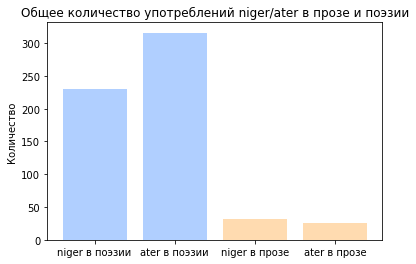

In [4]:
total_uses = list(c.execute('SELECT sum(niger_count), sum(ater_count), type from texts GROUP by type'))

for type_of_text in total_uses:
    print(type_of_text)

X = [1, 2]
X2 = [3, 4]
Y = [total_uses[0][0], total_uses[0][1]]
Y2 = [total_uses[1][0], total_uses[1][1]]
labels = ['niger в поэзии', 'ater в поэзии', 'niger в прозе', 'ater в прозе']
plt.bar(X, Y, color='#B0CFFF')
plt.bar(X2, Y2, color='#FFDBB0')
plt.xticks(ticks=X+X2, labels=labels)
plt.title('Общее количество употреблений niger/ater в прозе и поэзии')
plt.ylabel('Количество')
plt.show()

Рассмотрим отдельно прозу:

[(31, 26, 'prose')]


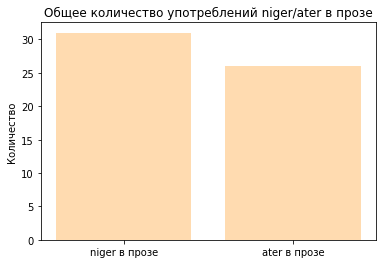

In [5]:
prose_uses = list(c.execute('SELECT sum(niger_count), sum(ater_count), type from texts WHERE type = "prose" GROUP by type'))

print(prose_uses)

X = [1, 2]
Y = [prose_uses[0][0], prose_uses[0][1]]
labels = ['niger в прозе', 'ater в прозе']
plt.bar(X, Y, color='#FFDBB0')
plt.xticks(ticks=X, labels=labels)
plt.title('Общее количество употреблений niger/ater в прозе')
plt.ylabel('Количество')
plt.show()

Рассмотрим отдельно, как употребляют прилагательные авторы прозы:

In [8]:
niger_percentage_prose = list(c.execute
                              ("""SELECT author, sum(niger_count) * 100 / (sum(niger_count) + sum(ater_count)) as percentage,
                              sum(niger_count), sum(ater_count)
                              from texts where type = "prose" group by author order by percentage desc"""))

for row in niger_percentage_prose:
    print(row)

('Непот', 100, 1, 0)
('Светоний', 100, 4, 0)
('Витрувий', 70, 7, 3)
('Сенека', 58, 7, 5)
('Цицерон', 58, 7, 5)
('Тацит', 50, 2, 2)
('Апулей', 21, 3, 11)
('Гирций', None, 0, 0)
('Неизвестно', None, 0, 0)
('Саллюстий', None, 0, 0)
('Цезарь', None, 0, 0)


Теперь рассмотрим поэзию:

[(230, 316, 'poetry')]


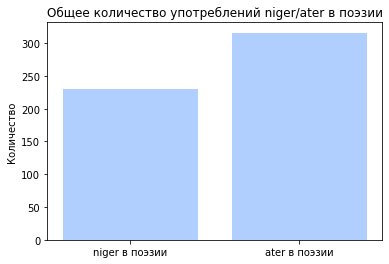

In [10]:
poetry_uses = list(c.execute('SELECT sum(niger_count), sum(ater_count), type from texts WHERE type = "poetry" GROUP by type'))

print(poetry_uses)

X = [1, 2]
Y = [poetry_uses[0][0], poetry_uses[0][1]]
labels = ['niger в поэзии', 'ater в поэзии']
plt.bar(X, Y, color='#B0CFFF')
plt.xticks(ticks=X, labels=labels)
plt.title('Общее количество употреблений niger/ater в поэзии')
plt.ylabel('Количество')
plt.show()

И отдельно по авторам:

In [12]:
niger_percentage_poetry = list(c.execute
                              ("""SELECT author, sum(niger_count) * 100 / (sum(niger_count) + sum(ater_count)) as percentage,
                              sum(niger_count), sum(ater_count)
                              from texts where type = "poetry" group by author order by percentage desc"""))

for row in niger_percentage_poetry:
    print(row)

('Кальпурний', 100, 2, 0)
('Персий', 100, 3, 0)
('Ювенал', 84, 16, 3)
('Манилий', 75, 9, 3)
('Лукреций', 68, 20, 9)
('Гораций', 56, 14, 11)
('Гомер', 50, 1, 1)
('Овидий', 50, 29, 29)
('Стаций', 49, 50, 51)
('Лукан', 48, 14, 15)
('Валерий', 45, 14, 17)
('Вергилий', 32, 38, 80)
('Силий', 17, 20, 97)
('Катулл', None, 0, 0)


Попробуем сделать биграммы:

In [29]:
def get_ngrams(directory):
    
    bigram_ater = []
    bigram_niger = []
    
    for filename in os.listdir(directory): #обходим циклом каждый файл в папке
        path = os.path.join(directory, filename)
        with open(path, encoding='utf-8-sig') as f: #считываем текст из файла
            text = f.read()
            
        text = text.lower()
        text = re.sub(r'[^\w\s]','',text) #обрабатываем текст (пунктуация, регистр)
        j.replace(text) #v,j -> u,i
        lemmatized_text = lemmatizer.lemmatize(text) #лемматизируем текст
        
        for lemma in range(len(lemmatized_text)): #находим нужные нам прилагательные и записываем их вместе с соседними словами
            if lemmatized_text[lemma] == 'niger':
                bigram_niger.append((lemmatized_text[lemma-1], lemmatized_text[lemma]))
                bigram_niger.append((lemmatized_text[lemma], lemmatized_text[lemma+1]))
            if lemmatized_text[lemma] == 'ater1':
                bigram_ater.append((lemmatized_text[lemma-1], lemmatized_text[lemma]))
                bigram_ater.append((lemmatized_text[lemma], lemmatized_text[lemma+1]))
        
    return bigram_niger, bigram_ater  

In [40]:
def print_ngram(counter):
    a = 0
    while a < 10:
        print(str(counter[a][0][0]) + ' ' + str(counter[a][0][1]) + '\t' + str(counter[a][1]))
        a += 1

Делаем Counter'ы, чтобы выводить биграммы:

In [ ]:
prose_bigram_niger = get_ngrams('prose')[0]
prose_bigram_ater = get_ngrams('prose')[1]
poetry_bigram_niger = get_ngrams('poetry')[0]
poetry_bigram_ater = get_ngrams('poetry')[1]

prose_niger_counter = collections.Counter(prose_bigram_niger).most_common()
prose_ater_counter = collections.Counter(prose_bigram_ater).most_common()
poetry_niger_counter = collections.Counter(poetry_bigram_niger).most_common()
poetry_ater_counter = collections.Counter(poetry_bigram_ater).most_common()

Печатаем получившиеся биграммы:

<i>niger</i> в прозе: 

In [41]:
print_ngram(prose_niger_counter)

et niger	3
niger edo1	2
niger qui1	2
qui1 niger	2
niger dico2	2
herba niger	1
niger cum	1
nocturnus niger	1
palla niger	1
niger splendescens	1


<i>ater</i> в прозе: 

In [42]:
print_ngram(prose_ater_counter)

et ater1	4
ater1 non	3
sanguis ater1	2
denticulus ater1	1
ater1 venenum	1
an ater1	1
ater1 edo1	1
bilis ater1	1
ater1 socio	1
paries ater1	1


<i>niger</i> в поэзии: 

In [43]:
print_ngram(poetry_niger_counter)

et niger	27
qui1 niger	7
aut niger	5
niger nox	4
niger vir	4
niger fero	4
niger sub	4
niger et	4
turbo2 niger	4
niger video	3


<i>ater</i> в поэзии: 

In [44]:
print_ngram(poetry_ater_counter)

et ater1	20
nox ater1	15
atque ater1	14
ater1 qve	9
ater1 in	8
ignis ater1	7
ater1 dies	6
nubis ater1	5
ater1 et	5
ater1 hic	5
